In [ ]:
# 데이터 데이터셋 로드

In [4]:
from pycocotools.coco import COCO
import os

# 경로 설정
data_dir = "coco"
ann_file = "coco/annotations/instances_val2017.json"

# COCO API 로드
coco = COCO(ann_file)

# 카테고리 확인
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
print("COCO Categories:", category_names)

# val2017 이미지 개수 확인
img_ids = coco.getImgIds()
print(f"Number of images in val2017: {len(img_ids)}")


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
COCO Categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Number of images in val2017: 5000


In [ ]:
# 모델 성능 평가

In [25]:
import torch
import torchvision.transforms as T
from PIL import Image
import requests
from pycocotools.coco import COCO
import os

# DETR 모델 로드
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()

# 이미지 변환 함수 (DETR에 맞게 변환)
transform = T.Compose([
    T.Resize(800),  # DETR 모델은 800px 크기로 입력
    T.ToTensor(),
])

# COCO 데이터셋 로드
data_dir = "coco"
ann_file = "coco/annotations/instances_val2017.json"
coco = COCO(ann_file)

# 첫 번째 이미지 선택
img_ids = coco.getImgIds()
img_info = coco.loadImgs(img_ids[0])[0]
img_path = os.path.join(data_dir, "val2017", img_info["file_name"])

# 이미지 로드 및 변환
image = Image.open(img_path).convert("RGB")
img_tensor = transform(image).unsqueeze(0)  # 배치 차원 추가

# 모델 추론
with torch.no_grad():
    outputs = model(img_tensor)

# 출력 확인
print("Model Outputs pred_logits:", outputs['pred_logits'].shape)
print("Model Outputs pred_boxes:", outputs['pred_boxes'].shape)


Using cache found in C:\Users\avdc/.cache\torch\hub\facebookresearch_detr_main
C:\Users\avdc\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\avdc\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
Model Outputs pred_logits: torch.Size([1, 100, 92])
Model Outputs pred_boxes: torch.Size([1, 100, 4])


In [ ]:
# DETR 결과 시각화

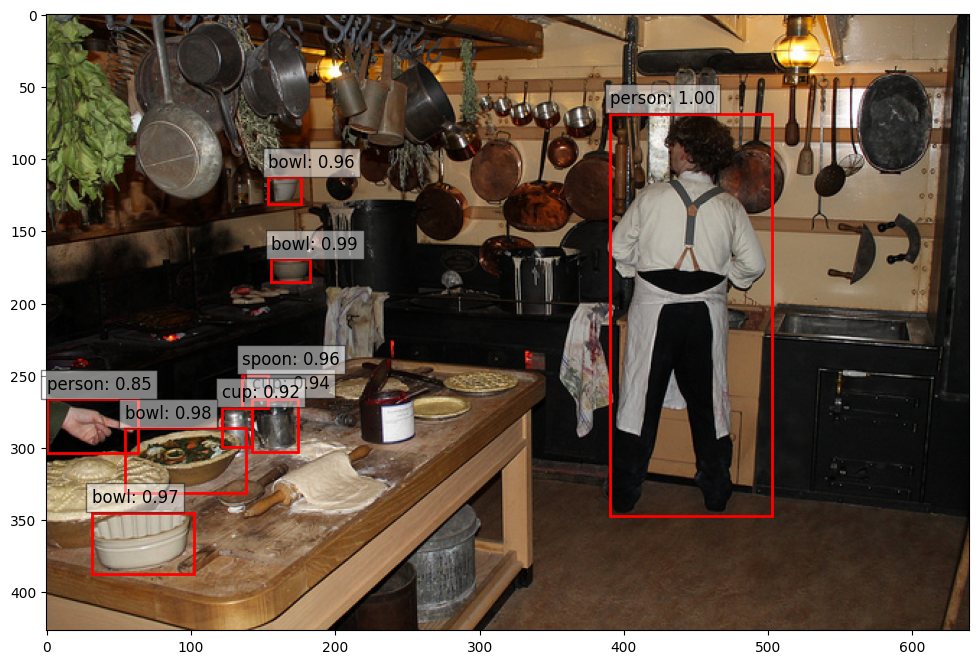

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# COCO 클래스 ID 로드
CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella',
    'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet',
    'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 예측값 가져오기
scores = outputs["pred_logits"].softmax(-1)[0, :, :-1].max(-1)[0]  # 각 객체의 confidence score
threshold = 0.7  # confidence score 기준
keep = scores > threshold  # 기준보다 높은 값만 선택

# 박스 가져오기
bboxes = outputs["pred_boxes"][0, keep].cpu().numpy()
labels = outputs["pred_logits"].softmax(-1)[0, keep].argmax(-1).cpu().numpy()
scores = scores[keep].cpu().numpy()

# 이미지 시각화
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# 박스 그리기
for bbox, label, score in zip(bboxes, labels, scores):
    x_c, y_c, w, h = bbox
    xmin, xmax, ymin, ymax = x_c-0.5*w, x_c+0.5*w, y_c-0.5*h, y_c+0.5*h
    W, H = image.size
    xmin, xmax, ymin, ymax = W*xmin, W*xmax, H*ymin, H*ymax
    
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin-7, f"{CLASSES[label]}: {score:.2f}", color="black", fontsize=12, bbox=dict(facecolor="white", alpha=0.5))

plt.show()


In [23]:
import torch
import torchvision.transforms as T
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
import json
from tqdm import tqdm

# DETR 모델 로드
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 이미지 변환 함수
transform = T.Compose([
    T.Resize(800, max_size=1333),  # 가장 짧은 변을 800으로 조정, 긴 변이 1333을 넘지 않도록 제한
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet 정규화
])

# COCO 데이터셋 로드
data_dir = "coco"
ann_file = "coco/annotations/instances_val2017.json"
coco = COCO(ann_file)

# 모든 이미지 ID 가져오기
img_ids = coco.getImgIds()

# DETR 클래스 ID는 0부터 시작하지만 COCO는 1부터 시작 -> 이를 고려해야 함
detections = []

# 모든 val2017 이미지에 대해 예측 수행
for img_id in tqdm(img_ids, desc="Processing COCO val2017"):
    # 이미지 정보 가져오기
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, "val2017", img_info["file_name"])
    
    # 이미지 로드 및 변환
    image = Image.open(img_path).convert("RGB")
    W, H = image.size
    img_tensor = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가

    # 모델 추론
    with torch.no_grad():
        outputs = model(img_tensor)

    # 예측된 confidence score
    scores = outputs["pred_logits"].softmax(-1)[0, :, :-1].max(-1)[0]  
    labels = outputs["pred_logits"].softmax(-1)[0, :, :-1].argmax(-1)  
    bboxes = outputs["pred_boxes"][0].cpu().numpy()

    # Confidence threshold 설정
    threshold = 0.5
    keep = scores > threshold

    # Mask valid predicts
    masked_scores = scores[keep]
    masked_labels = labels[keep]
    masked_bboxes = bboxes[keep.cpu()]


    # DETR 결과를 COCO 평가 형식으로 변환
    for i, bbox in enumerate(masked_bboxes):

        x_c, y_c, w, h = bbox
        xmin, xmax, ymin, ymax = x_c-0.5*w, x_c+0.5*w, y_c-0.5*h, y_c+0.5*h
        xmin, xmax, ymin, ymax = W*xmin, W*xmax, H*ymin, H*ymax

        detection = {
            "image_id": img_id,
            "category_id": int(masked_labels[i]),
            "bbox": [float(xmin), float(ymin), float(xmax - xmin), float(ymax - ymin)],
            "score": float(masked_scores[i])
        }
        
        detections.append(detection)

# 예측 결과를 JSON 파일로 저장 (COCO API를 위해 필요)
detection_file = "coco_detections.json"
with open(detection_file, "w") as f:
    json.dump(detections, f)
    # json.dump(detections, f, default=lambda x: float(x))



Using cache found in C:\Users\avdc/.cache\torch\hub\facebookresearch_detr_main


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


Processing COCO val2017: 100%|█████████████████████████████████████████████████████| 5000/5000 [04:01<00:00, 20.68it/s]


In [24]:
coco_gt = COCO("coco/annotations/instances_val2017.json")
coco_pred = coco_gt.loadRes("coco_detections.json")
coco_eval = COCOeval(coco_gt, coco_pred, "bbox")

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.11s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.588
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets